# Lab 3 — dimensionality reduction

In [37]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle


from operator import itemgetter
from pyspark.sql import functions as F

%matplotlib inline
plt.style.use("ggplot")

In [38]:
!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 2

{"tagId": 1127, "tag": "zombie"}
{"tagId": 1128, "tag": "zombies"}


In [39]:
sc

In [40]:
genome_tags_RDD = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
tag2name = dict(genome_tags_RDD.map(itemgetter("tagId", "tag")).collect())

In [41]:
len(tag2name)

1128

In [42]:
genome_scores_RDD = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
# genome_scores = data.collect() # RDD IS TOO BIG

### Exercise 3.1 

In [7]:
tag2name

{1: '007',
 2: '007 (series)',
 3: '18th century',
 4: '1920s',
 5: '1930s',
 6: '1950s',
 7: '1960s',
 8: '1970s',
 9: '1980s',
 10: '19th century',
 11: '3d',
 12: '70mm',
 13: '80s',
 14: '9/11',
 15: 'aardman',
 16: 'aardman studios',
 17: 'abortion',
 18: 'absurd',
 19: 'action',
 20: 'action packed',
 21: 'adaptation',
 22: 'adapted from:book',
 23: 'adapted from:comic',
 24: 'adapted from:game',
 25: 'addiction',
 26: 'adolescence',
 27: 'adoption',
 28: 'adultery',
 29: 'adventure',
 30: 'affectionate',
 31: 'afi 100',
 32: 'afi 100 (laughs)',
 33: 'afi 100 (movie quotes)',
 34: 'africa',
 35: 'afterlife',
 36: 'aging',
 37: 'aids',
 38: 'airplane',
 39: 'airport',
 40: 'alaska',
 41: 'alcatraz',
 42: 'alcoholism',
 43: 'alien',
 44: 'alien invasion',
 45: 'aliens',
 46: 'allegory',
 47: 'almodovar',
 48: 'alone in the world',
 49: 'alter ego',
 50: 'alternate endings',
 51: 'alternate history',
 52: 'alternate reality',
 53: 'alternate universe',
 54: 'amazing cinematography',

In [43]:
movies_rdd = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)

131262

In [44]:
movies = movies_rdd.collect()

In [45]:
len(movies)

27278

In [50]:
smaller_genome_scores_RDD = genome_scores_RDD.filter(lambda x: x['movieId'] == 31 and x['tagId'] <= 4)

genome_scores = smaller_genome_scores_RDD.collect()

genome_scores

[{'movieId': 31, 'relevance': 0.04099999999999998, 'tagId': 1},
 {'movieId': 31, 'relevance': 0.05125000000000002, 'tagId': 2},
 {'movieId': 31, 'relevance': 0.020500000000000018, 'tagId': 3},
 {'movieId': 31, 'relevance': 0.032999999999999974, 'tagId': 4}]

In [51]:
genome_scores_DF = genome_scores_RDD.toDF(['movieId', 'relevance', 'tagId'])

/usr/hdp/2.5.3.0-37/spark/python/pyspark/sql/context.py:259: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [52]:
genome_groups = genome_scores_DF.groupBy('movieId').agg(F.collect_list('relevance'), F.collect_list('tagId'))

In [53]:
g = genome_groups.collect()

In [54]:
M_matrix = np.zeros( (len(tag2name), len(g)) ) 
M_matrix.shape

(1128, 10381)

In [55]:
M_matrix_movieIds = []

In [56]:
total_relevances = []

In [62]:
for movie, row in enumerate(g):
    movieId = row[0]
    relevances = row[1]
    tags = row[2]
    
    M_matrix_movieIds.append(movieId)
    
    for relevance, tag in zip(relevances, tags):
        M_matrix[tag - 1, movie] = relevance
        total_relevances.append(relevance)

In [96]:
M_matrix

array([[ 0.041  ,  0.04425,  0.027  , ...,  0.01825,  0.0385 ,  0.068  ],
       [ 0.05125,  0.04825,  0.02725, ...,  0.024  ,  0.03875,  0.08525],
       [ 0.0205 ,  0.01925,  0.01975, ...,  0.076  ,  0.024  ,  0.0215 ],
       ..., 
       [ 0.01225,  0.0115 ,  0.01125, ...,  0.01125,  0.0175 ,  0.009  ],
       [ 0.08025,  0.07825,  0.07225, ...,  0.076  ,  0.16825,  0.96475],
       [ 0.01675,  0.01425,  0.01825, ...,  0.01825,  0.0275 ,  0.93775]])

#### Save M_matrix to pickle

In [72]:
with open('M_matrix.pickle', 'wb') as handle:
    pickle.dump(M_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [179]:
with open('M_matrix_movieIds.pickle', 'wb') as handle:
    pickle.dump(M_matrix_movieIds, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
#Load from pickle

with open('M_matrix.pickle', 'rb') as handle:
    M_matrix = pickle.load(handle)
    
with open('M_matrix_movieIds.pickle', 'rb') as handle:
    M_matrix_movieIds = pickle.load(handle)

### Explore the data

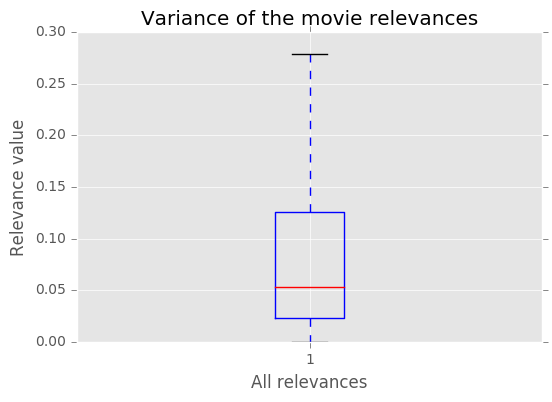

In [99]:
plt.boxplot(total_relevances, 0, '')
plt.title("Variance of the movie relevances")
plt.ylabel('Relevance value')
plt.xlabel('All relevances')
plt.show()

As visible in the boxplot above, majority of the movie tags is irrelevant for the given movie - mean value of movie relevance is slightly above 0.05.

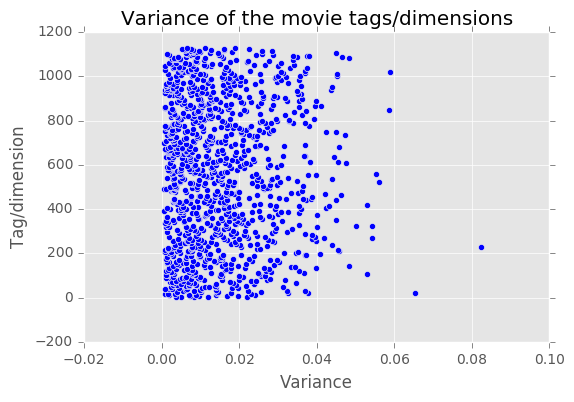

In [100]:
M_matrix_variance = np.var(M_matrix, axis=1)
plt.scatter(M_matrix_variance, range(1, len(M_matrix_variance)+1))
plt.title("Variance of the movie tags/dimensions")
plt.ylabel('Tag/dimension')
plt.xlabel('Variance')
plt.show()

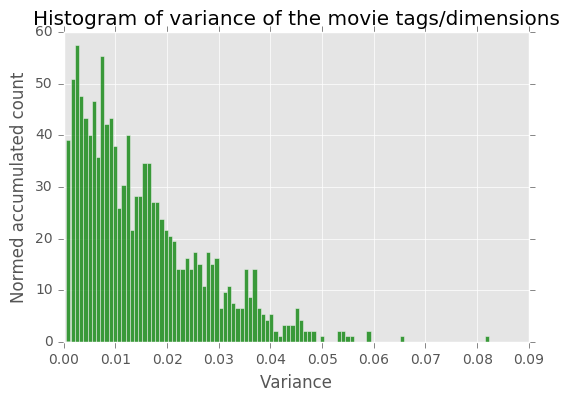

In [109]:
plt.hist(M_matrix_variance, bins=100, normed=1, facecolor='green', alpha=0.75)
plt.title("Histogram of variance of the movie tags/dimensions")
plt.ylabel('Normed accumulated count')
plt.xlabel('Variance')
plt.show()

As visible on the scatter plot and histogram above, most of the tags/dimensions have 
very low variance thus, most of the movies containing same tag have similair relevance. 

Let's check what are the top 5 tags with highest variance:

In [104]:
indices = np.argsort(M_matrix_variance)
max_5_variance_tag = [ tag2name[index] for index in indices[-5:] ]
max_5_variance_tag

['horrible', 'reflective', 'television', 'absurd', 'colourful']

Indeed these are ambiguous tags and could easily vary from one movie to another.

What about lowest variance tags:

In [106]:
low_5_variance_tag = [ tag2name[index] for index in indices[:5] ]
low_5_variance_tag

['nazis', 'fighting the system', 'handycam', 'neil gaiman', 'cinematography']

These tags are much less ambiguous - movie cannot be only slightly nazi, handycam or cinematography.


#### Eigenvalues

In [69]:
# covariance matrix of M
M_matrix_no_mean = M_matrix - np.array([np.mean(M_matrix, axis=1)]).T
M_cov = np.cov(M_matrix_no_mean)
M_cov

array([[ 0.00490042,  0.00327346, -0.00030115, ...,  0.00016838,
        -0.00016172, -0.00014599],
       [ 0.00327346,  0.00374098, -0.00023234, ...,  0.00011866,
        -0.00015645, -0.00014514],
       [-0.00030115, -0.00023234,  0.01184989, ...,  0.00130349,
        -0.00112118, -0.00035662],
       ..., 
       [ 0.00016838,  0.00011866,  0.00130349, ...,  0.0188282 ,
        -0.00114338, -0.00032847],
       [-0.00016172, -0.00015645, -0.00112118, ..., -0.00114338,
         0.01105378,  0.00659333],
       [-0.00014599, -0.00014514, -0.00035662, ..., -0.00032847,
         0.00659333,  0.00658031]])

In [70]:
eigvalues, eigvectors = np.linalg.eigh(M_cov)

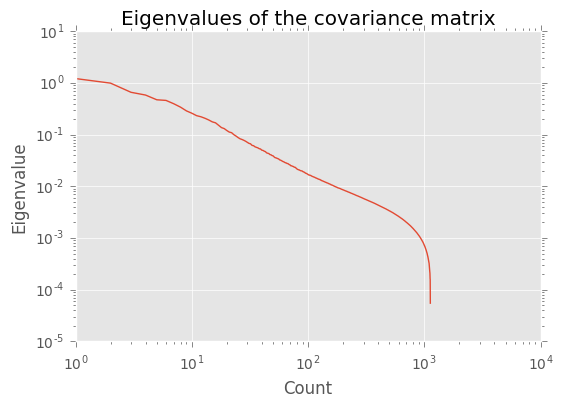

In [110]:
eigvalues_plot = eigvalues.tolist()
eigvalues_plot.reverse()
plt.loglog(eigvalues_plot)
plt.title("Eigenvalues of the covariance matrix")
plt.ylabel('Eigenvalue')
plt.xlabel('Count')
plt.show()

Unsurprisingly majority of the eigenvalues are quite small - only 20 first eigenvalues are above 0.1.

How many principal directions do we need to capture 2/3 of the variability in the data?



In [72]:
cumulative = (np.cumsum(eigvalues_plot) / np.sum(eigvalues))

most_significant_principal_directions = [ n for n,i in enumerate(cumulative) if i>((2./3) ) ][0]
most_significant_principal_directions

36

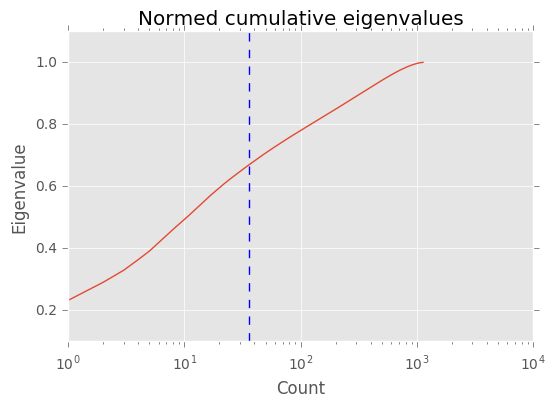

In [111]:
plt.semilogx(cumulative)
plt.title("Normed cumulative eigenvalues")
plt.ylabel('Eigenvalue')
plt.xlabel('Count')
plt.axvline(most_significant_principal_directions, linestyle='dashed')
plt.show()

Only 36 first eigenvalues and thus pricipal directions capture 2/3 of the variability in the data. This means that our huge, over 1k dimensional space can be projected to only 36 dimensional space, and still it would contain 2/3 of all the information contained in original data space. This is an extreme advantage of PCA method when it comes to dimensinality reduction, since it preserves most of the information in only few principal components.

#### Exercise 3.2 Concept space

For the five first principal directions, find the 10 tags that have the highest and lowest
coordinates in that direction.

• What concepts would you use to describe these dimensions?

Create a Python dict which maps every tag (name) to its coordinates in the 5 first principal directions and save it to disk. This will be used later for the clustering exercise.

In [13]:
# A * x = lambd * x = PCA

In [75]:
first_five_eigenvalues = eigvalues_plot[:5]
first_five_eigenvalues

[2.7533774797813515,
 1.2214710425886666,
 0.9960515193084871,
 0.6621755002074047,
 0.5857297851139422]

In [76]:
eigvectors

array([[ 0.00205699, -0.0053407 ,  0.0062789 , ...,  0.00124553,
        -0.01383799, -0.00572728],
       [-0.00078554, -0.00303118,  0.00347284, ...,  0.00206112,
        -0.01048045, -0.00478882],
       [ 0.00044356, -0.00104207,  0.00037798, ...,  0.02393293,
         0.00278201,  0.01246704],
       ..., 
       [ 0.00093566, -0.00050236,  0.00263286, ...,  0.03252862,
        -0.00551248,  0.01719115],
       [-0.00228662,  0.01518848,  0.00429738, ..., -0.0399581 ,
        -0.01417361, -0.01026643],
       [ 0.00059397, -0.01100711, -0.00067457, ..., -0.01634403,
        -0.00551606, -0.00137267]])

In [77]:
first_five_eigenvectors = eigvectors[:,-5:].T
first_five_eigenvectors = first_five_eigenvectors[::-1] # flip the order back to correct (highest to lowest)
first_five_eigenvectors

array([[-0.00572728, -0.00478882,  0.01246704, ...,  0.01719115,
        -0.01026643, -0.00137267],
       [-0.01383799, -0.01048045,  0.00278201, ..., -0.00551248,
        -0.01417361, -0.00551606],
       [ 0.00124553,  0.00206112,  0.02393293, ...,  0.03252862,
        -0.0399581 , -0.01634403],
       [-0.00645959, -0.00525968,  0.01488517, ..., -0.01063545,
         0.00476552,  0.0037956 ],
       [ 0.00537026,  0.00320727,  0.02648181, ...,  0.03512377,
        -0.01902386, -0.00852925]])

In [116]:
# verify that order of eigenvalues and eigenvectors is correct
verification = np.zeros(1128)
for i, val in enumerate(first_five_eigenvalues):
    verification += (first_five_eigenvalues[i]*first_five_eigenvectors[i])\
    - (np.dot(M_cov, first_five_eigenvectors[i]))

# if verification ~= 0 then correct order
np.sum(verification)

2.6206323555980592e-14

In [115]:
for i in range(5):  
    indices = np.argsort(eigvectors[:, -(i+1)])
    lowest_10 = indices[:10]
    top_10 = indices[-10:][::-1]
    print('\nEigenvector {}\n'.format(i+1))
    print('Top vs. lowest')
    for top, low in zip(top_10, lowest_10):
        print("{: >20} {: >20}".format(tag2name[top], tag2name[low]))


Eigenvector 1

Top vs. lowest
     talking animals      powerful ending
              soccer               snakes
     crime gone awry           bad ending
         imagination               silent
               great                silly
             dragons            hong kong
oscar (best cinematography)               france
      blaxploitation             kurosawa
               drama             biblical
                 cia            colourful

Eigenvector 2

Top vs. lowest
 interracial romance               absurd
          reflective              special
     crime gone awry             biblical
          meditative      character study
           lone hero              fashion
                 god             survival
            medieval          good acting
                 art      pixar animation
         melancholic                   pg
          sex comedy               action

Eigenvector 3

Top vs. lowest
     feel good movie             horrible
      self discove

• What concepts would you use to describe these dimensions?

NOTE! 
We verified with TAs that tags returned are not entirely correct however we (team Y + TAs) were not able to poinpoint bug in our logic/code, thus we proceeded as it is.

For first principal direction (ignoring outliers as dragons or talking animals and considering following: [oscar, drama, great] vs. [snakes, silly, colourful]) we could use concept space as following: critically acclaimed, seriousness

Second principal direction ([reflective, meditative, melancholic, art] vs. [absurd, special, biblical, survival, action] concept space:
pace, mood, tempo

Third principal direction ([feel good movie, love, romance] vs. [vigilantism, distopia, horrible]) concept space:
emotions, feelings

Fourth principal direction ([visually appealing, visual, beautiful scenery] vs. [creepy, survival]) concept space:
perception, visual-style

Fifth principal direction ([suspense, murder, secret service] vs. [funniest movies, humor, funny]) concept space:
tension, stress

Create a Python dict which maps every tag (name) to its coordinates in the 5 first principal directions and save it to disk. This will be used later for the clustering exercise. 

In [51]:
eigenspace = np.dot(first_five_eigenvectors, M_matrix_no_mean)
projection = np.dot(M_matrix_no_mean, eigenspace.T)
projection.shape

(1128, 5)

In [55]:
tags_mapped = {}

for key, value in tag2name.items():
    tags_mapped[value] = projection[key-1,:]

In [56]:
tags_mapped

{'disney': array([-477.98651415, -104.54968489,  328.25811066,  126.06741198,
         -45.6655703 ]),
 'sacrifice': array([ 1257.94692642,  -621.62189176,   672.73709505,   216.83509965,
          202.09260886]),
 'memory': array([ 495.82292071, -213.488369  ,  -18.08087493,  319.63944544,
          86.93572867]),
 'oscar (best editing)': array([ 492.81837607, -307.21132635,  229.47919567,  -60.22215485,
           0.98346369]),
 'vampires': array([-122.19344284,  -60.29919702, -140.5159688 ,   37.72474032,
         -34.13822488]),
 'oscar (best cinematography)': array([ 1660.10523649,  -209.88375507,   478.6100259 ,    15.72317529,
          185.17975576]),
 'dark': array([ 2041.86658817,  -453.20560412,  -961.42041515,    78.56925044,
          -82.20988289]),
 'good sequel': array([-423.4545227 , -457.04207296,   -4.31515757,   97.22323194,
         -52.52470938]),
 'disability': array([ 421.8160066 ,    3.85482631,  235.81987049,   16.80105104,
         -70.93824365]),
 'mockument

In [72]:
### Save to pickle
with open('tag_embedding.pickle', 'wb') as handle:
    pickle.dump(projection, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [71]:
### Save to pickle
with open('tags_mapped.pickle', 'wb') as handle:
    pickle.dump(tags_mapped, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Exercise 3.3 Movie visualization

In [117]:
#Load from pickle
with open('selected-movies.pickle', 'rb') as handle:
    selected_movies = pickle.load(handle, encoding='utf-8') # encoding='latin1'

In [118]:
selected_movies

((780, 'Independence Day (a.k.a. ID4) (1996)', 0.6),
 (5349, 'Spider-Man (2002)', 0.89),
 (2571, 'Matrix, The (1999)', 0.87),
 (318, 'Shawshank Redemption, The (1994)', 0.91),
 (2329, 'American History X (1998)', 0.83),
 (5147, 'Wild Strawberries (Smultronstället) (1957)', 0.95),
 (55444, 'Control (2007)', 0.87),
 (32296, 'Miss Congeniality 2: Armed and Fabulous (2005)', 0.15),
 (43930, 'Just My Luck (2006)', 0.13),
 (4658, 'Santa Sangre (1989)', 0.85),
 (6774, 'Videodrome (1983)', 0.78),
 (3967, 'Billy Elliot (2000)', 0.85),
 (114028, 'Pride (2014)', 0.92),
 (480, 'Jurassic Park (1993)', 0.93),
 (260, 'Star Wars: Episode IV - A New Hope (1977)', 0.93),
 (4700, 'Princess Diaries, The (2001)', 0.47),
 (527, "Schindler's List (1993)", 0.96),
 (2959, 'Fight Club (1999)', 0.79),
 (6132, 'New York Ripper, The (Squartatore di New York, Lo) (1982)', 0.17),
 (2858, 'American Beauty (1999)', 0.88),
 (6016, 'City of God (Cidade de Deus) (2002)', 0.9),
 (94018, 'Battleship (2012)', 0.34),
 (5687,

In [119]:
len(selected_movies)

37

In [120]:
indeces = []
names = []
ratings = []
for row in selected_movies:
    movieId = row[0]
    movieName = row[1]
    movieRating = row[2]
    
    index_in_M_matrix = M_matrix_movieIds.index(movieId)
    indeces.append(index_in_M_matrix)
    names.append(movieName)
    ratings.append(movieRating)

In [121]:
selected_M_matrix = M_matrix[:,indeces]
selected_M_matrix.shape

(1128, 37)

In [122]:
pca_2d = first_five_eigenvectors.T[:,:2]
pca_2d.shape

(1128, 2)

In [123]:
projected = pca_2d.T.dot(selected_M_matrix)
projected.shape

(2, 37)

In [124]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
import matplotlib as mpl
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import HoverTool
output_notebook()


output_file("selected_ratings.html")

source = ColumnDataSource(
        data=dict(
            x=projected[0,:],
            y=projected[1,:],
            desc=names,
            rating=ratings
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("Name", "@desc"),
            ("Rating", "@rating"),
        ]
    )

p = figure(plot_width=400, plot_height=400, tools=[hover],
           title="Visualization of selected movies")
p.xaxis.axis_label = 'First Principal Direction'
p.yaxis.axis_label = 'Second Principal Direction'

colors = [
    "#%02x%02x%02x" % (255-int(r), int(g), 0) for r, g, b, _ in 255*mpl.cm.viridis(mpl.colors.Normalize()(ratings))
]
p.circle('x', 'y', fill_alpha=0.2, color=colors, size=10, source=source)

show(p)

Loading BokehJS ...

• Based on your knowledge of these movies and information that you can get from the
web, explain the coordinates of a few of the movies.

It seems like first principal direction corresponds to 'seriousness' and 'critically acclaimed' concept space since movies with high value for 1st principal direction are heavy known dramas, whilst movies with low value are silly comedies. 

Second principal direction on the other hand seems to describe 'pace, mood, tempo' of the movie since movies with low value for this direction are high action sci-fi movies while movies with higher values seem to be more slow.

• How do the PCA directions correlate with the Rotten Tomatoes score?

Judging by the color distribution in our visualisation it seems like there exists some slight correlation of Rotten Tomatoes score with first principal direction as most movies with low value for first direction have also low rating.

In [182]:
#TODO? prove correlation?